# File formats for memmapping
- Exploring which file formats are good for memmapping datasets
- Measuring mem usage when openning and sampling with multiple sub-processes (as well as total RAM imapct)
- End goal is to get pandas dataframes, since that's the most useful scenario (?). Getting whole memmapped dataframes is not always possible, so batching is the next best thing
- Using pandas2 and pyarrow
- Conclusion: Numpy for simple datasets, Feather for real-world data.

Summary:
1. CSVs: no memmaps, 2.5x storage size, blows mem up when reading
2. Numpy Arrays: elegant and simple. Can't have metadata or multiple dtypes. Can be memmapped entirely as dataframes. Useful for simple datasets.
3. Pyarrow Parquet: Uses compression so can't fully memmap. Fast io, but does use a lot of mem.
4. Pyarrow Feather: Fast IO, can memmap but no zero-copy cast to pandas. Preferred way when using diverse data.
5. HDF5: Can't memmap directly, but can use hack to read numpy arrays. Would have to use block manager to deal with multiple dtypes. 

In [1]:
import os
import time
import psutil
import asyncio
import datetime
import functools
import numpy as np
import pandas as pd
import pyarrow as pa
from pyarrow import feather, parquet
import threading
import multiprocessing
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool

## 0. Experimental setup
- Generate a modest dataset of 4GB 
- For simplicity using numeric tabular format, however in practice we prefer something with more semantics/metadata
- Measure how long and how much memory it takes to open and return a subset of rows
- Using two subprocesses to see how much copy is needed, hopefully none in the case of true memmaps
- Measure how much memory is consumed by looking at resident memory per process and total RAM usage on the machine
- Also plot the theoretical sum of process RSS as a baseline. Should sum up to total RAM in case of no shared mem.
- The memory profiling is done via running a separate thread in the background that uses psutils

In [2]:
def benchmark(func, title="", **kwargs) -> dict:
    """Log total ram usage (virt used) and per process RSS"""
    queue = multiprocessing.SimpleQueue()
    ram = ThreadPool(processes=1).apply_async(monitor_memory, (queue, False))

    func = functools.partial(func, **kwargs)
    with multiprocessing.Pool(processes=2,) as pool:
        p1, p2 = pool.map(worker, [func]*2)
        
    queue.put("stop")
    ram = ram.get()
    
    # Plotting
    min_dt = min(ram.index[0], p1.index[0], p2.index[0])
    min_len = min(len(ram), len(p1), len(p2))
    ram.index = (ram.index - min_dt).total_seconds()
    p1.index = (p1.index - min_dt).total_seconds()
    p2.index = (p2.index - min_dt).total_seconds()
    psum = pd.Series(p1.values[:min_len] + p2.values[:min_len], index=ram.index[:min_len])
    
    plt.figure(figsize=(20, 5))
    plt.plot(ram, label="RAM Used")
    plt.plot(p1, label="p1 RSS")
    plt.plot(p2, label="p2 RSS")
    plt.plot(psum, label="sum", linestyle="dashed")
    
    plt.title(title)
    plt.ylabel("GB")
    plt.xlabel("Seconds")
    plt.legend()
    plt.show()
    
    return {"name": title, "peak": ram.max(), "time": ram.index[-1]}

def worker(func, **kargs):
    """
    Run the loader and log RSS
    """
    
    queue = multiprocessing.SimpleQueue()
    mem = ThreadPool(processes=1).apply_async(monitor_memory, (queue, True))
    
    func()
    
    queue.put("stop")
    return mem.get() 

def monitor_memory(queue, process=False) -> pd.Series:
    """RSS if process, else used virtual memory (system)"""
    dts, mems = [], []
    while queue.empty():
        mem = psutil.Process().memory_info().rss if process else psutil.virtual_memory().used
        mems.append(mem / 2**30)
        dts.append(datetime.datetime.now())
        time.sleep(1)
    res = pd.Series(mems, index=dts)
    res = res - res.iloc[0]
    return res

In [3]:
arr = np.random.randn(int(5e5), int(1e3))
print(f"{arr.nbytes / 2**30:.2f} GB mem as inmem np")

3.73 GB mem as inmem np


In [4]:
df = pd.DataFrame(arr, columns=[str(x) for x in range(arr.shape[1])])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 3.7 GB


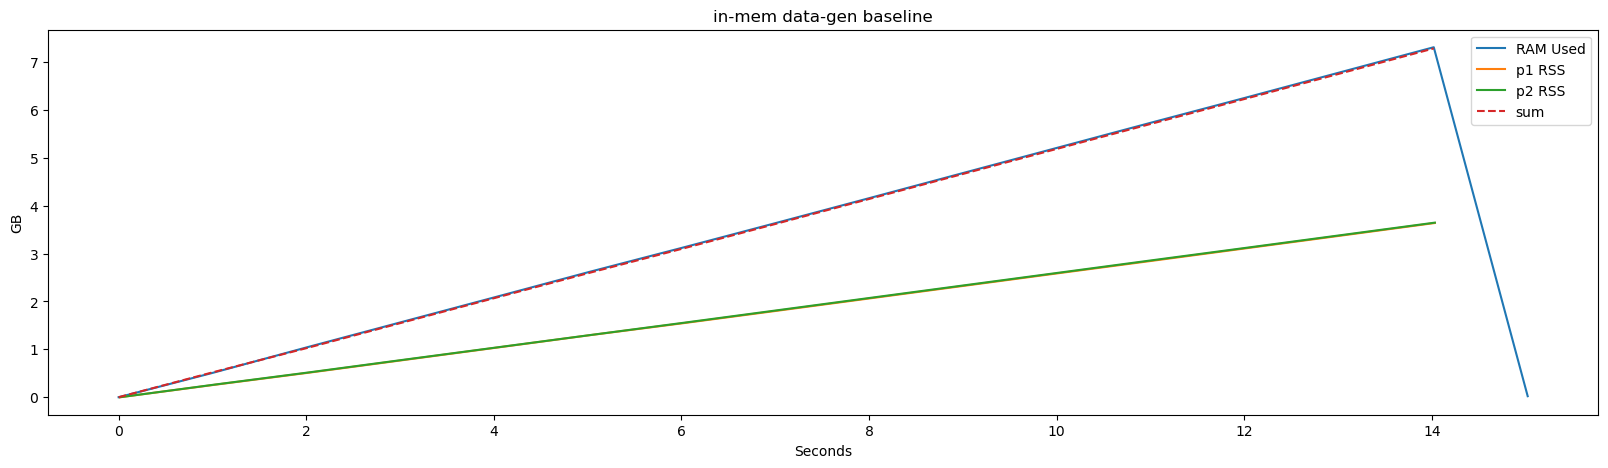

{'name': 'in-mem data-gen baseline',
 'peak': 7.309680938720703,
 'time': 15.020812}

In [7]:
# test
def create_arr():
    arr = np.random.randn(int(5e5), int(1e3))
    df = pd.DataFrame(arr)

benchmark(create_arr, "in-mem data-gen baseline")

## 1. Csv
- 3.73 GB in-mem table of float64 is saved as 9.14 GB csv on disk (almost 2.5x)
- Note: memmapping doesn't make any sense here since data has to be parsed first, hence having an in-memory copy
- Don't know what memmapping flag in pandas should be doing
- pandas read_csv has multiple engines (c, pyarrow, python). C is the default and fastest one. Pyarrow and python explode mem

In [8]:
%%time
df.to_csv("/tmp/test_mmap.csv")

CPU times: user 6min 48s, sys: 7.52 s, total: 6min 55s
Wall time: 6min 59s


In [9]:
print(f"{os.path.getsize('/tmp/test_mmap.csv') / 2**30:.2f} GB mem as disk csv")

9.14 GB mem as disk csv


In [10]:
def load_csv(memory_map=False, engine="c"):
    df = pd.read_csv("/tmp/test_mmap.csv", memory_map=memory_map, engine=engine)
    time.sleep(1)
    df.iloc[1000: 2000]
    

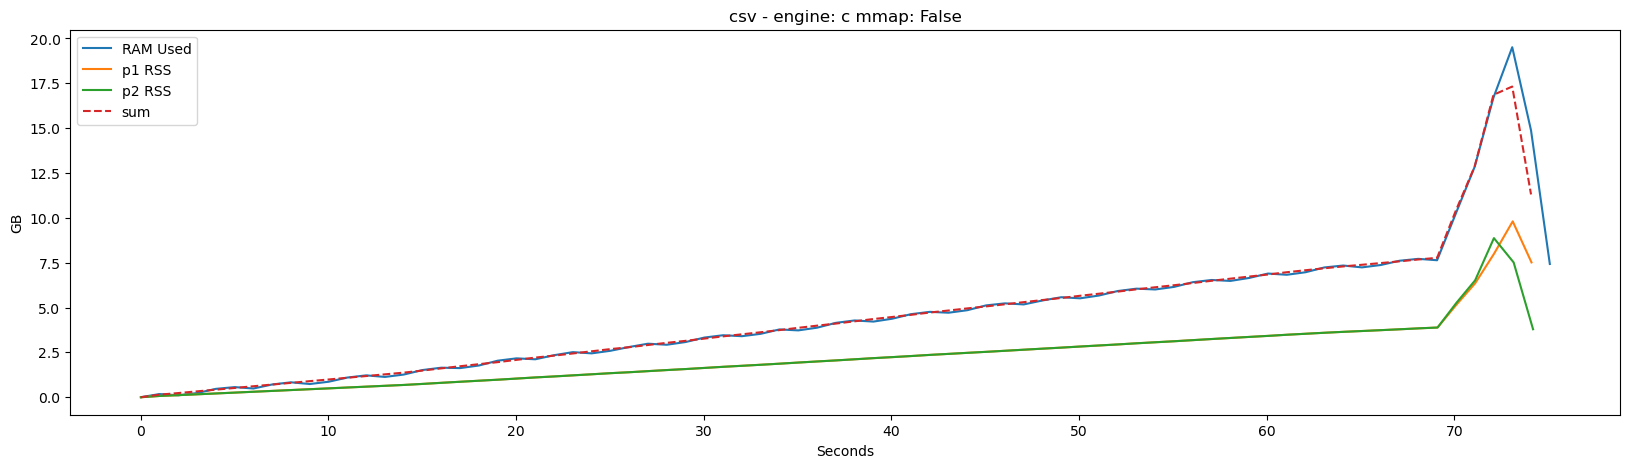

{'name': 'csv - engine: c mmap: False',
 'peak': 19.510921478271484,
 'time': 75.087337}

In [15]:
benchmark(load_csv, title=f"csv - engine: c, mmap: False", engine="c", memory_map=False)

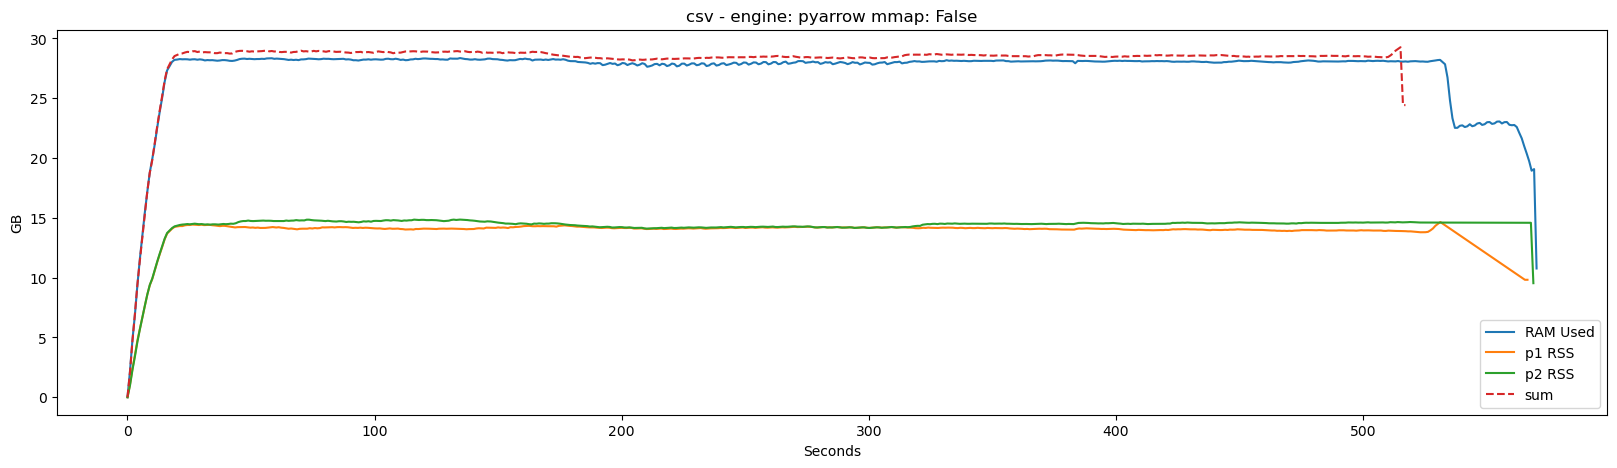

{'name': 'csv - engine: pyarrow mmap: False',
 'peak': 28.361835479736328,
 'time': 570.163272}

In [16]:
benchmark(load_csv, title=f"csv - engine: pyarrow, mmap: False", engine="pyarrow", memory_map=False)

## 2. Numpy
- Numpy memmaps are great because they are simple and work well
- However, they don't store any metadata (col names, indices, etc) that make dataframes useful; they are also of single dtype hence not allowing for mixed type datasets
- Can be used to create full zero-copy dataframes
- Great for toy/simplified datasets, not so useful for commercial data

### 2.1 Writing

In [6]:
%%time
mmap = np.memmap("/tmp/test_mmap.npy", mode="w+", dtype=np.float64, shape=(500000, 1000))
mmap[:] = arr[:]
mmap.flush()
print(f"{os.path.getsize('/tmp/test_mmap.npy') / 2**30:.2f} GB on disk npy")

3.73 GB on disk npy
CPU times: user 1.12 s, sys: 2.77 s, total: 3.9 s
Wall time: 53.8 s


In [23]:
%%time

pre_mem = psutil.Process().memory_info().rss

table1 = pd.DataFrame(np.memmap("/tmp/test_mmap.npy", mode="r", dtype=np.float64, shape=(500000, 1000)))
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)
table2 = pd.DataFrame(np.memmap("/tmp/test_mmap.npy", mode="r", dtype=np.float64, shape=(500000, 1000)))
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)
table3 = pd.DataFrame(np.memmap("/tmp/test_mmap.npy", mode="r", dtype=np.float64, shape=(500000, 1000)))
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)

Mem used: 0.0
Mem used: 0.0
Mem used: 0.0
CPU times: user 1.68 ms, sys: 490 µs, total: 2.17 ms
Wall time: 1.54 ms


### 2.2 Mem benchmark

In [30]:
def load_npy():
    table = pd.DataFrame(np.memmap("/tmp/test_mmap.npy", mode="r", dtype=np.float64, shape=(500000, 1000)))
    for idx in np.random.randint(0, 1e5, size=10):
        time.sleep(1)
        batch = table[idx: idx + 1000]
        batch.sum() # should trigger a read

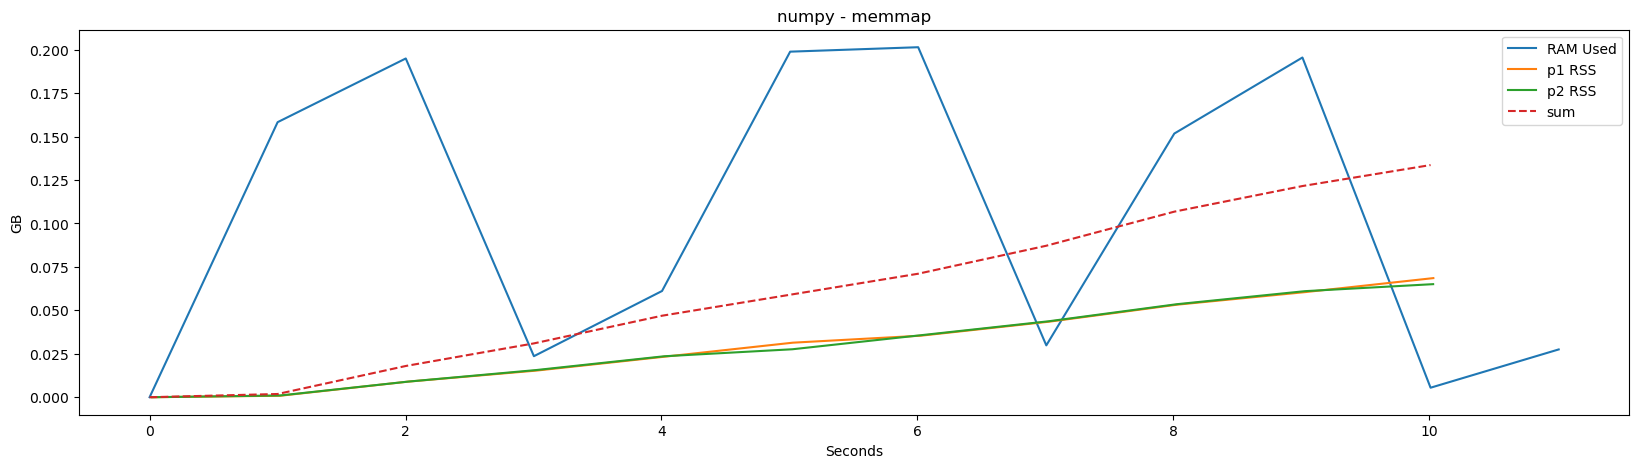

{'name': 'numpy - memmap', 'peak': 0.20145416259765625, 'time': 11.011099}

In [29]:
benchmark(load_npy, title=f"numpy - memmap")

## 3. Parquet
- Pq format is compressed, so similar to csvs using memmaps might not make sense since data has to be decompressed first and only then somehow memshared
- Storage size is failry close to in-mem. Given that data has been generated randomly it is not surprising that compression didn't have a significant impact
- For some reason there is the memmap option when reading the pyarrow table. doesn't really memmap though.
- With memmaping flag memory consumption is additive with no of processes. Without mem consumption goes through the roof. Not sure what's happening there

### 3.1 Writing

#### Default Compression

In [5]:
%%time
df.to_parquet("/tmp/test_mmap.pq", engine="pyarrow", compression="SNAPPY")
print(f"{os.path.getsize('/tmp/test_mmap.pq') / 2**30:.2f} GB on disk parquet")

3.99 GB on disk parquet
CPU times: user 34.3 s, sys: 12 s, total: 46.3 s
Wall time: 1min 6s


In [6]:
%%time
table1 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table2 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table3 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)

Mem used: 3.7835240364074707
Mem used: 7.567048072814941
Mem used: 11.350572109222412
CPU times: user 24.9 s, sys: 11.1 s, total: 36.1 s
Wall time: 3.6 s


#### No Compression

In [5]:
%%time
df.to_parquet("/tmp/test_mmap.pq", engine="pyarrow", compression="NONE")
print(f"{os.path.getsize('/tmp/test_mmap.pq') / 2**30:.2f} GB on disk parquet")

3.99 GB on disk parquet
CPU times: user 35.4 s, sys: 12.8 s, total: 48.2 s
Wall time: 1min 6s


In [6]:
%%time
table1 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table2 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table3 = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)

Mem used: 3.7835240364074707
Mem used: 7.567048072814941
Mem used: 11.350572109222412
CPU times: user 11.9 s, sys: 8.41 s, total: 20.4 s
Wall time: 2.25 s


### 3.2 Mem Benchmark

In [3]:
def load_pq(memory_map=True):
    table = pa.parquet.read_table("/tmp/test_mmap.pq", memory_map=memory_map)
    for idx in np.random.randint(0, 1e5, size=10):
        time.sleep(1)
        batch = table[idx: idx + 1000].to_pandas()

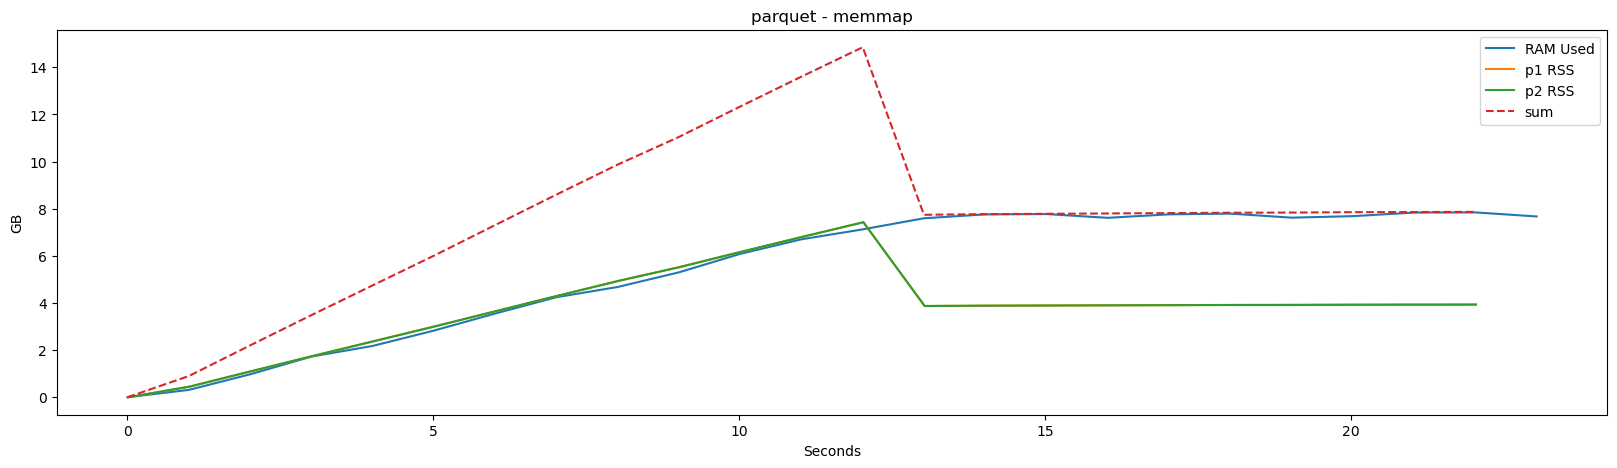

{'name': 'parquet - memmap', 'peak': 7.842292785644531, 'time': 23.028003}

In [4]:
benchmark(load_pq, title=f"parquet - memmap", memory_map=True)

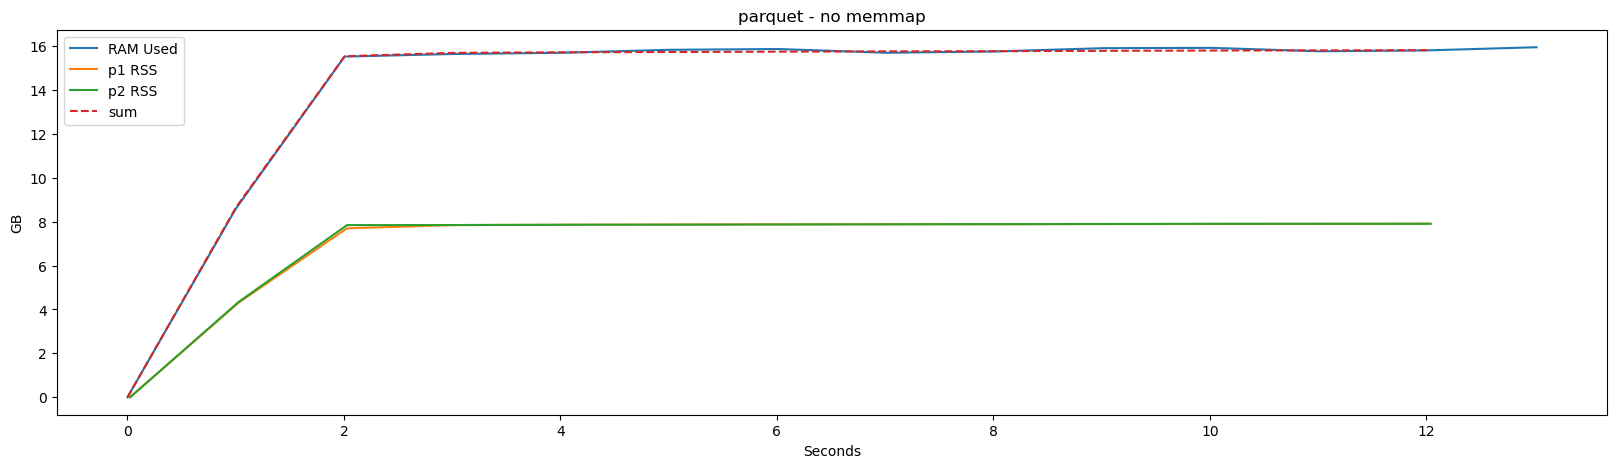

{'name': 'parquet - no memmap', 'peak': 15.952049255371094, 'time': 13.018065}

In [5]:
benchmark(load_pq, title=f"parquet - no memmap", memory_map=False)

## 4. Feather
- Feather is the native Arrow format, which is all about cool memory representations. so it should be great for memmaps
- It is: fast to read,write and allows for easy memmaps. 
- Note: can't use compressed writing if want to use memmaps
- Can't pass the pyarrow table to pandas with zero-copy though, so would have to stick with batching

### 4.1 Writing

In [6]:
%%time
df.to_feather("/tmp/test_mmap.feather", compression=None) # Use default compression
print(f"{os.path.getsize('/tmp/test_mmap.feather') / 2**30:.2f} GB on disk feather")

3.73 GB on disk feather
CPU times: user 23 s, sys: 6.71 s, total: 29.7 s
Wall time: 56.2 s


In [7]:
%%time
table1 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table2 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table3 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)

Mem used: 3.725290298461914
Mem used: 7.450580596923828
Mem used: 11.175870895385742
CPU times: user 3.72 s, sys: 10.8 s, total: 14.5 s
Wall time: 1.65 s


In [5]:
%%time
df.to_feather("/tmp/test_mmap.feather", compression="uncompressed") # No compression
print(f"{os.path.getsize('/tmp/test_mmap.feather') / 2**30:.2f} GB on disk feather")

3.73 GB on disk feather
CPU times: user 21.3 s, sys: 6.3 s, total: 27.6 s
Wall time: 53.2 s


In [6]:
%%time
table1 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table2 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)
table3 = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=True)
print("Mem used:", pa.total_allocated_bytes() / 2**30)

Mem used: 0.0
Mem used: 0.0
Mem used: 0.0
CPU times: user 12.2 ms, sys: 4.03 ms, total: 16.2 ms
Wall time: 15.3 ms


### 4.2 Men Benchmark

In [16]:
def load_feather(memory_map=True):
    table = pa.feather.read_table("/tmp/test_mmap.feather", memory_map=memory_map)
    
    for idx in np.random.randint(0, 1e5, size=10):
        time.sleep(1)
        batch = table[idx: idx + 1000].to_pandas()

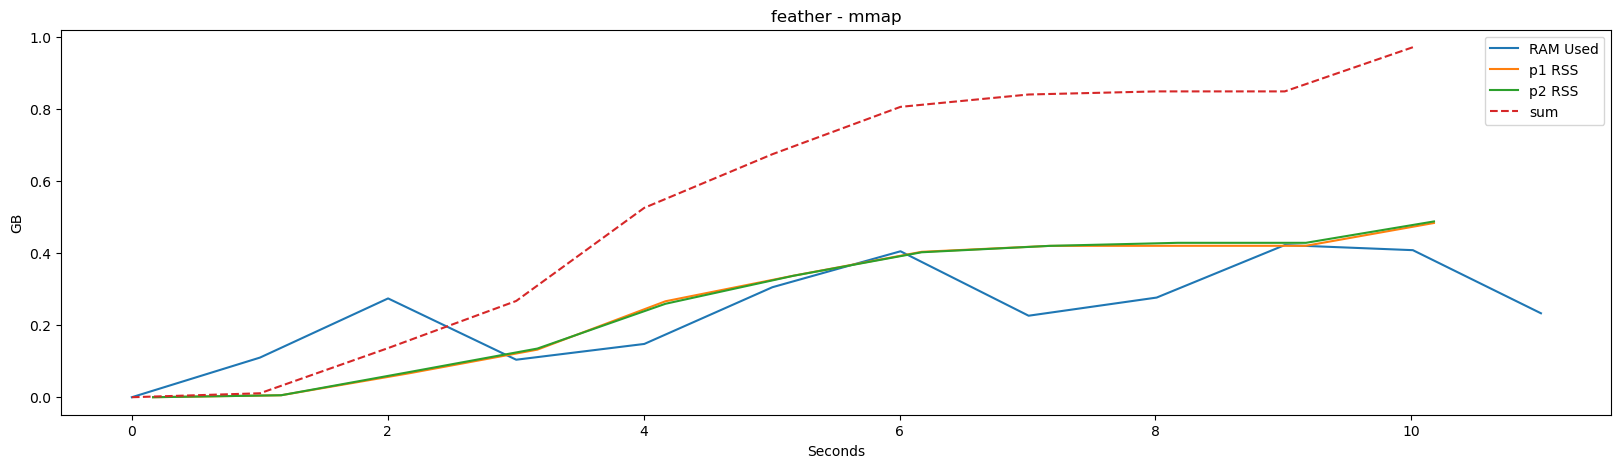

{'name': 'feather - mmap', 'peak': 0.4226036071777344, 'time': 11.013439}

In [17]:
benchmark(load_feather, title=f"feather - mmap", memory_map=True)

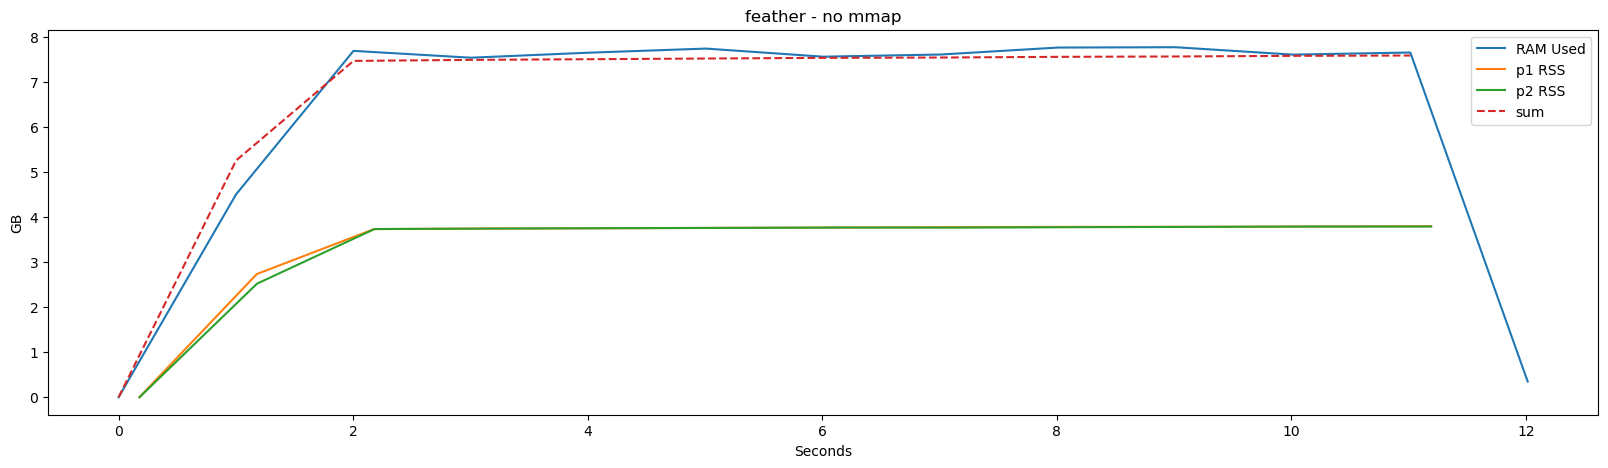

{'name': 'feather - no mmap', 'peak': 7.765308380126953, 'time': 12.014622}

In [18]:
benchmark(load_feather, title=f"feather - no mmap", memory_map=False)

## 5. HDF5
- Don't know of any official ways to read hdf as memmaps
- nifty trick to open numpy array memmaps directly from hdf
- Basically same as using np if setup is simple
- For multiple types/blocks more advanced pandas usage of blockmanager is necessary

### 5.1 Writing

In [35]:
%%time

df.to_hdf("/tmp/test_mmap.h5", key="a", format="fixed")
print(f"{os.path.getsize('/tmp/test_mmap.h5') / 2**30:.2f} GB on disk HDF5")

3.73 GB on disk HDF5
CPU times: user 1.11 s, sys: 1.72 s, total: 2.84 s
Wall time: 20.4 s


In [78]:
from h5py import File, Dataset

def get_metadata(path: str):
# https://gist.github.com/maartenbreddels/09e1da79577151e5f7fec660c209f06e
    h5file = File(path, 'r')
    # maps from hdf5 path to metadata
    arrays_metadata = {}
    def f(name, item):
        is_dataset = isinstance(item, Dataset)
        #print(name, item, 'dataset' if is_dataset else 'group')
        if is_dataset:
            offset = item.id.get_offset()
            if offset is not None:
                arrays_metadata[name] = dict(offset=offset, shape=item.shape, dtype=item.dtype)
            else:
                print('could not get offset, probably not a continuous array')
    h5file.visititems(f)
    return arrays_metadata

def get_df_from_hdf(path, key="a") -> pd.DataFrame:
    """
    Memmapped, assumes single block
    """
    metadata = get_metadata(path)
    return pd.DataFrame(
        data=np.memmap(path, mode='r', dtype=metadata[f"{key}/block0_values"]["dtype"], offset=metadata[f"{key}/block0_values"]["offset"], shape=metadata[f"{key}/block0_values"]["shape"]),
        index=np.memmap(path, mode='r', dtype=metadata[f"{key}/axis1"]["dtype"], offset=metadata[f"{key}/axis1"]["offset"], shape=metadata[f"{key}/axis1"]["shape"]),
        columns=np.memmap(path, mode='r', dtype=metadata[f"{key}/axis0"]["dtype"], offset=metadata[f"{key}/axis0"]["offset"], shape=metadata[f"{key}/axis0"]["shape"]),
    )

In [81]:
%%time

pre_mem = psutil.Process().memory_info().rss

table1 = get_df_from_hdf("/tmp/test_mmap.h5")
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)
table2 = get_df_from_hdf("/tmp/test_mmap.h5")
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)
table3 = get_df_from_hdf("/tmp/test_mmap.h5")
print("Mem used:", (psutil.Process().memory_info().rss - pre_mem) / 2**30)

Mem used: 0.0
Mem used: 0.0
Mem used: 0.0
CPU times: user 6.43 ms, sys: 189 µs, total: 6.62 ms
Wall time: 5.95 ms


### 5.2 Mem Benchmark

In [82]:
def load_hdf5():
    table = get_df_from_hdf("/tmp/test_mmap.h5")
    for idx in np.random.randint(0, 1e5, size=10):
        time.sleep(1)
        batch = table[idx: idx + 1000]
        batch.sum() # should trigger a read

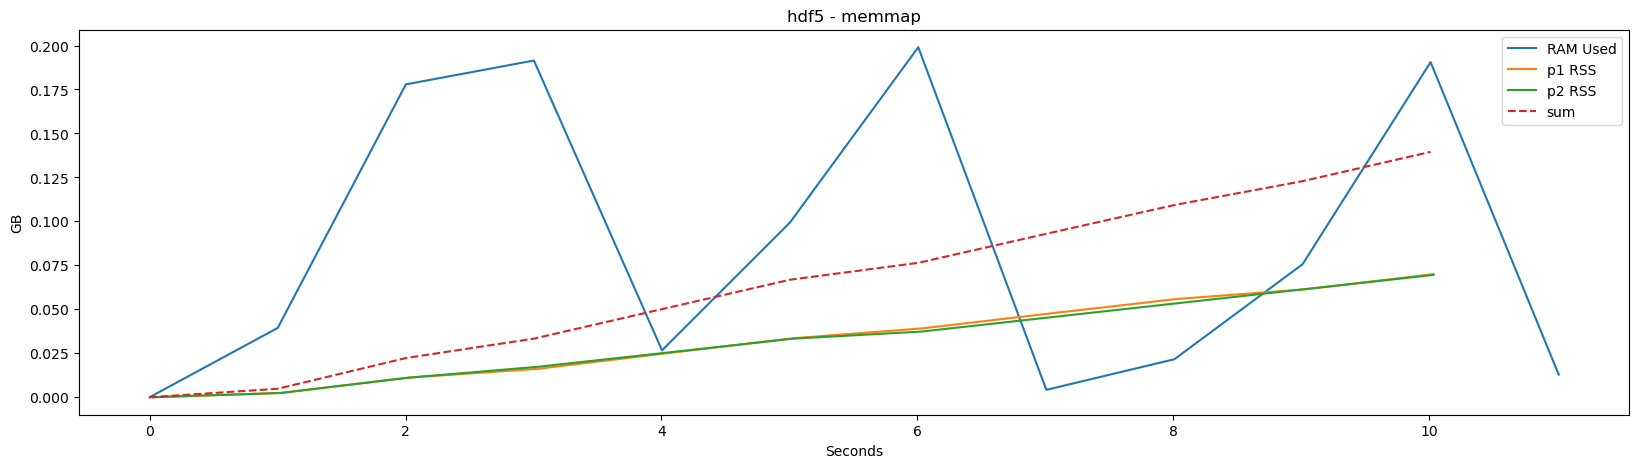

{'name': 'hdf5 - memmap', 'peak': 0.19902801513671875, 'time': 11.013078}

In [83]:
benchmark(load_hdf5, title=f"hdf5 - memmap")